In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import materials_propellant as mp
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
def zvezda(D, omega, rho_t, e_0, n, theta, r):
    """Функция расчета горения заряда с каналом звездообразного сечения. Возвращает словарь с результатами и функции зависимостей \n
    площади поверхности горения заряда и параметра Победоносцева от толщины сгоревшего свода

    Args:
        D (float): внутренний диаметр КС
        omega (float): масса топлива
        rho_t (float): плотность топлива
        e_0 (float): толщина свода
        n (int): количество лучей звезды
        theta (float): полуугол выступа заряда
        r (float): радиус скругления

    Returns:
        dict: словарь результатов следующего типа:
            {
                'eps_f' (float): коэффициент заполнения поперечного сечения КС
                'kappa_0' (float): начальное значение параметра Победоносцева
                'ksi_degr' (float): массовая доля дегрессивных остатков
                'l' (float): длина заряда из условия размещения заданной массы топлива с учетом действительного заполнения
                'S_sr' (float): среднее значение плотногсти горения (с учетом дегрессивных остатков e = 0..e_0)
                'e_1': толщина сгоревшего свода в конце первой стадии
                'e_2': толщина сгоревшего свода в конце второй стадии
                'e_3': толщина сгоревшего свода в конце горения
            }
        S(e) (func): зависимость площади поверхности горения заряда от толщины сгоревшего свода
        kappa(e) (func): зависимость параметра Победоносцева от толщины сгоревшего свода
    """

    beta = np.pi / n
    R = D / 2 - e_0 - r
    F = 0.25 * np.pi * (D ** 2)
    
    # стадия 1
    alfa = (np.pi / 2) - theta + beta
    b = lambda e: R * ((np.sin(beta)) / (np.sin(theta))) - (r + e) * (1 / np.tan(theta))
    e_1 = R * (np.sin(beta) / np.cos(theta)) - r

    # стадия 2
    alfa2 = lambda e: beta + np.arcsin((R / (r+e)) * np.sin(beta))

    # стадия 3
    dalfa = lambda e: np.arccos(((D ** 2 / 4) - (R**2) - ((r + e)**2)) / (2 * R * (r+e)))
    alfa3 = lambda e: alfa2(e) - dalfa(e)
    e_3 = np.sqrt((D**2 / 4) + (R ** 2) - (D * R * np.cos(beta))) - r
    
    # периметр горения
    def Per(e):
        if e <= e_1:
            return 2 * n * (alfa * (r + e) + b(e))
        elif e <= e_0:
            return 2 * n * alfa2(e) * (r + e)
        elif e <= e_3:
            return 2 * n * alfa3(e) * (r + e)
        else:
            return 0
    
    # площадь горящего свода
    F_sv = lambda e: quad(Per, 0, e)[0]
    F_all = F_sv(e_3)
    F_0 = F_sv(e_0)
    
    # коэффициент заполнения
    eps_f = F_all / F
    
    # длина заряда
    L = omega / (rho_t * F_all)
    L_0 = omega / (rho_t * F_0)
    
    # площадь горения
    S = lambda e: Per(e) * L_0
    S_sr = quad(S, 0, e_0)[0] / e_0

    kappa_0 = S(0) / (F * (1 - eps_f))
    kappa = lambda e: S(e) / (F - (F_all - F_sv(e)))

    e_mas = np.linspace(0,e_3+0.004, 500)
    S_mas = np.array([S(e) for e in e_mas])
    kappa_mas = np.array([kappa(e) for e in e_mas])
    
    S = interp1d(e_mas,S_mas)
    Perf = interp1d(e_mas,S_mas/L_0)
    kappa = interp1d(e_mas,kappa_mas)
    
    # result = {
    #     'eps_f': eps_f,
    #     'kappa_0': kappa_0,
    #     'l': L,
    #     'S_sr': S_sr,
    #     'e_1': e_1,
    #     'e_2': e_0,
    #     'e_3': e_3
    # }
    result = L

    F_sv1 = lambda e: n*(alfa*(r + e)**2 + (R*np.sin(beta)/np.sin(theta) - \
                      (r + e)*np.tan(theta)**(-1))*((r + e) + R*np.cos(alfa)) + \
                      R*(r + e)*np.sin(alfa))
    F_sv2 = lambda e: n*(alfa2(e)*(r + e)**2 + R*(r + e)*np.sin(alfa2(e)))
    dalpha_3 = lambda e: np.pi - np.arccos((R**2 + (r + e)**2 - (D/2)**2)/(2*R*(r + e)))
    alpha_3 = lambda e: alfa2(e) - dalpha_3(e)
    dbeta_3 = lambda e: np.arccos((R**2 + (D/2)**2 - (r + e)**2)/(R*D))
    F_sv3 = lambda e: n*(alpha_3(e)*(r + e)**2 + R*(r + e)*np.sin(alfa2(e)) + dbeta_3(e)*D**2/4 - R*D/2*np.sin(dbeta_3(e)))
    def F_sv(e):
        if e <= e_1:
            return F_sv1(e)
        elif e <= e_0:
            return F_sv2(e)
        elif e <= e_3:
            return F_sv3(e)
        else:
            return 0

    return result, S, Perf, F_sv

In [23]:
# D_nar = None

# параметы топлива
propellant = mp.get_mixed_propellant('20% ПБКГ, 64% ПХА, 16% ПХК')
rho_t = propellant['rho_т']
R_g = propellant['R_г']
k = propellant['k']
nu = propellant['nu']
u1 = propellant['u_1']/(1e6**nu)
T0 = propellant['T_0']
lambda_pr = 0.15    #????? взять из терры

chi = 0.906      # тепловые потери
p_k = 17.5e6      # опорное давление в камере
p_d1 = 21.5e6     # давление у переднего днища
nu_c = 0.95
d_kr = 0.0882
F_kr = np.pi * d_kr**2 / 4

# Параметры для определения периметра и длины заряда
D_nar_zar = 1
omega = 288
number_zv = 7
find_theta = lambda theta: np.pi/2 + np.pi/number_zv - theta - 1/np.tan(theta)
theta = fsolve(find_theta,np.deg2rad(35), xtol=1e-9)[0]
r_zv = 0.006
e0 = 0.0324
L_zar, S_zar, Per, F_k = zvezda(D_nar_zar,omega,rho_t,e0,number_zv,theta,r_zv)
# L_zar = 0.945

# ????
k_lambda = 1
S_b = lambda x,e: Per(e) * x

In [24]:
L_zar

0.17221103756248812

In [25]:
# гд функции
r = lambda lmbd: (1 - (k - 1) / (k + 1) * lmbd**2) / (1 + lmbd**2)
pi = lambda lmbd: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
y = lambda lmbd: ((k + 1) / 2) ** (1 / (k - 1)) * lmbd / (1 - (k - 1) / (k + 1) * lmbd ** 2)

dr_dt = lambda lmbd: - 4*k*lmbd / ((k + 1) * (lmbd**2 + 1)**2)

A = lambda k: np.sqrt(k * ((2 / (k + 1))**((k + 1) / (k - 1))))

fi = lambda lmbd: r(lmbd) + lmbd * dr_dt(lmbd)

# минус мильон расчетного времени
Ff_lambda_pr = quad(lambda lmbd: fi(lmbd) / r(lmbd),0,lambda_pr)[0]

def Ff(lmbd):
    if lmbd <= lambda_pr:
        return quad(lambda lmbd: fi(lmbd) / r(lmbd),0,lmbd)[0]
    else:
        Ff2 = lambda lmbd: fi(lmbd) / (r(lmbd) ** nu * (1 + k_lambda * (lmbd - lambda_pr)))
        return quad(Ff2,lambda_pr,lmbd)[0] + Ff_lambda_pr
Ff1 = lambda x,e,p_d: rho_t * S_b(x,e) * u1 / (p_d**(1 - nu) * F_k(e)) * \
    np.sqrt((k + 1) / (2*k) * chi * R_g * T0)

lambda_kan = lambda x,e,p_d = p_d1: fsolve(lambda lmbd: Ff1(x,e,p_d) - Ff(lmbd),0)[0]

In [26]:
xs = np.linspace(0,L_zar,101)
es = [0,0.25*e0,0.5*e0,0.75*e0,e0]
lambda_kans = {}
p1s = {}

for e in es:
    lambda_kans[e] = np.array([lambda_kan(x,e) for x in xs])
    p1s[e] = np.array([p_d1 * r(lambda_kani) for lambda_kani in lambda_kans[e]])

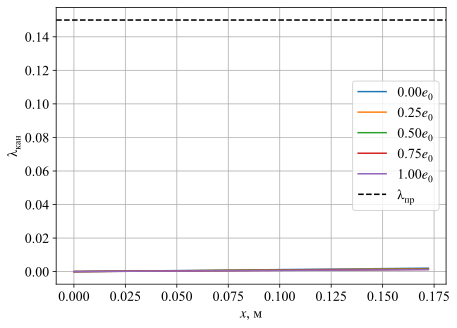

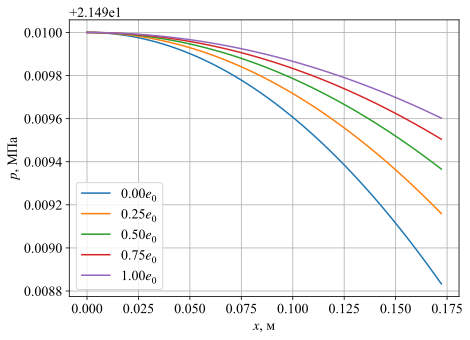

In [27]:
def graph(dicts,ylabel,filename = None,denominator = 3.45):
    plt.figure(figsize=(7,5))
    for e in es:
        plt.plot(xs,dicts[e]/denominator, label = f'{e/e0:.2f}' + '$\mathit{e}_0$')

    plt.xlabel('$\mathit{x}$, м')
    plt.ylabel(ylabel)
    plt.grid()
    if 'lambda' in filename:
        plt.axhline(lambda_pr,ls = '--',c = 'black',label = '$\\lambda_{пр}$')
    plt.legend()
    if filename:
        pass
        #plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

graph(lambda_kans,'$\\lambda_{кан}$','lambda_kan1.svg')
graph(p1s,'$\mathit{p}$, МПа','p1.svg',1e6)

In [28]:
p_news = p1s
lambda_kan_news = lambda_kans
pd_new = {}
for e in es:
    pd_new[e] = p_d1
while abs(p_news[es[-1]][-1] - p_k) > 1e2:
    for e in es:
        pd_new[e] = p_k + pd_new[e] - p_news[e][-1]
        lambda_kan_news[e] = np.array([lambda_kan(x,e,pd_new[e]) for x in xs])
        p_news[e] = np.array([pd_new[e] * r(lambda_kani) for lambda_kani in lambda_kan_news[e]])

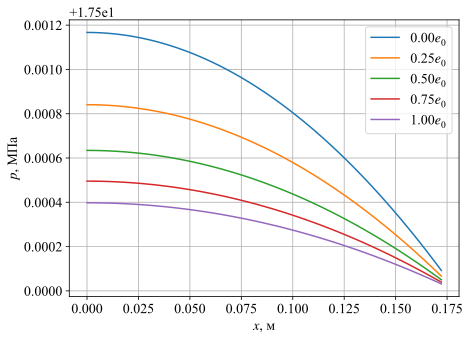

In [29]:
graph(p_news,'$\mathit{p}$, МПа','p_kon.svg',1e6)

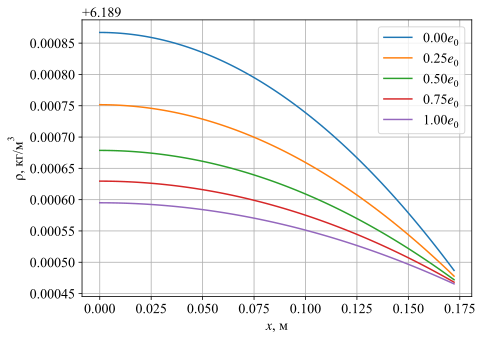

In [30]:
rhos = {}
for e in es:
    rhos[e] = p_news[e] / (R_g * T0)

graph(rhos,'$\\rho$, кг/$м^3$','rho.svg')

In [31]:
es2 = np.linspace(0,e0,100)
pd_kons = np.array(len(es2) * [p_d1])
lambda_kan_kons = np.array([lambda_kan(L_zar,e) for e in es2])
p_kons = np.array([p_d1 * r(lambda_kani) for lambda_kani in lambda_kan_kons])
while abs(p_kons[-1] - p_k) > 1e2:
    for i in range(len(es2)):
        pd_kons[i] = p_k + pd_kons[i] - p_kons[i]
        lambda_kan_kons[i] = lambda_kan(L_zar,es2[i],pd_kons[i])
        p_kons[i] = pd_kons[i] * r(lambda_kan_kons[i])

K_u, sigma_c, p_k2 = [], [], []
for lmbd,e in zip(lambda_kan_kons,es2):
    K_u.append((2 / (k + 1)) ** (1 / (k - 1)) * y(lmbd) * r(lmbd) ** (1 - nu) / Ff(lmbd))
    sigma_c.append(1 - 1.1 * k / (k + 1) * pi(lmbd) * lmbd ** 2)
    p_k21 = rho_t * S_b(L_zar,e) * K_u[-1] * u1 * np.sqrt(chi * R_g * T0)
    p_k22 = nu_c * A(k) * sigma_c[-1] * F_kr
    p_k2.append((p_k21 * pi(lmbd) / p_k22)**(1 / (1 - nu)) + 7134699.796769991)

In [32]:
p_k - np.mean(p_k2)

9142453.749305392

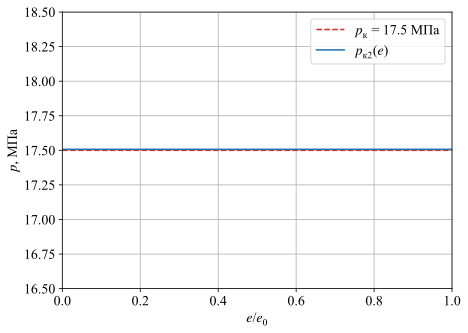

In [38]:
plt.figure(figsize=(7,5))
plt.axhline(p_k/1e6,c = 'tab:red',ls = '--',label = '$\mathit{p}_к$ = ' + f'{p_k/1e6:.1f} МПа')
plt.plot(es2/e0,np.array(p_k2)/1e6 + 9.15, label = '$\mathit{p}_{к2}(\mathit{e})$')

plt.xlabel('$\mathit{e}$/$\mathit{e}_0$')
plt.ylabel('$\mathit{p}$, МПа')
plt.ylim(p_k /1e6- 1,p_k/1e6 + 1)
plt.xlim(0,1)
plt.grid()
plt.legend()
#plt.savefig('pe.svg', dpi=300, bbox_inches='tight')
plt.show()

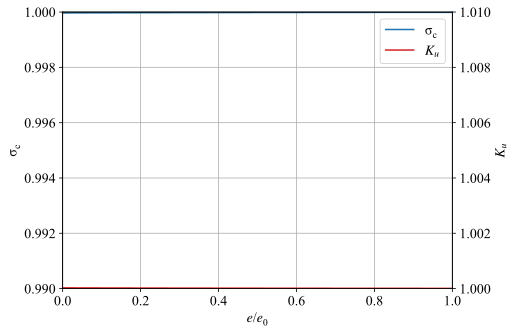

In [39]:
fig = plt.figure(figsize = (7,5), facecolor = 'white')
ax_sigma = fig.add_subplot(111)

axk = ax_sigma.twinx()

ax_sigma.set_xlim(0,1)
ax_sigma.set_ylim(0.99,1)
axk.set_ylim(1,1.01)

ax_sigma.set_xlabel('$\mathit{e}$/$\mathit{e}_0$')
ax_sigma.set_ylabel('$\\sigma_c$')
axk.set_ylabel('$\mathit{K_u}$')

ax_sigma.yaxis.set_ticks(np.linspace(0.99,1, 6))
axk.yaxis.set_ticks(np.linspace(1,1.01, 6))

p1, = ax_sigma.plot(es2/e0,sigma_c,c = 'tab:blue', label = '$\\sigma_c$')
p2, = axk.plot(es2/e0,K_u,c = 'tab:red', label = '$\mathit{K_u}$')

lns = [p1, p2]
axk.legend(handles = lns)
ax_sigma.grid()
#plt.savefig('sigma_and_K.svg', dpi=300, bbox_inches='tight')
plt.show()